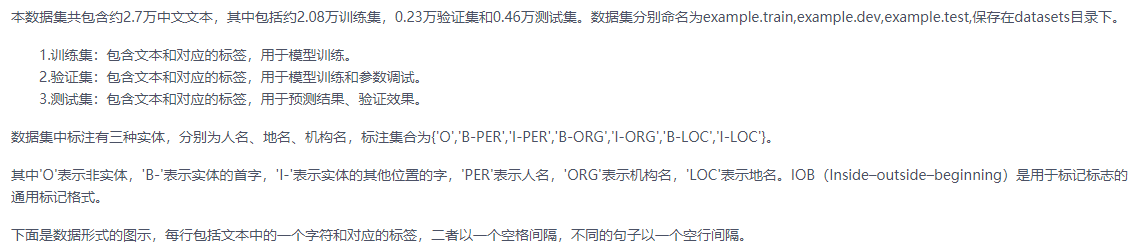

根据数据集中的字符建立字典，并保存在datasets/vocab.txt中，标签也可通过类似的方式保存在datasets/labels.txt，这里略去

# 实现数据来源 https://work.datafountain.cn/forum?id=148&type=2&source=1
# 模型参考 博客 https://blog.csdn.net/u010366748/article/details/113784204?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522163150251616780265483068%2522%252C%2522scm%2522%253A%252220140713.130102334.pc%255Fall.%2522%257D&request_id=163150251616780265483068&biz_id=&utm_medium=distribute.pc_search_result.none-task-code-2~all~first_rank_ecpm_v1~rank_v29_ecpm-24-113784204-0.pc_search_ecpm_flag&utm_term=TorchCRF.CRF

In [2]:
from collections import Counter
import math
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import warnings
import re
import jieba
warnings.filterwarnings('ignore')
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"] = ['Simhei']
plt.rcParams["axes.unicode_minus"] = False
from pylab import *
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from random import random
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from sklearn.metrics import f1_score
import torch.optim as optim
from torch.utils.tensorboard.writer import SummaryWriter
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
from torchcrf import CRF # Version: 1.1.0
SEED = 1210
from torchsummary import summary
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix, classification_report
def seed_everything(seed):
#     random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(SEED) #设置几乎所有的随机种子 随机种子，可使得结果可复现
torch.set_default_tensor_type(torch.FloatTensor) #如果想要创建变量类型都是Float32 类型

Using TensorFlow backend.


In [2]:
# 只运行一次就行了 
# def get_vocab_list(path_list):
#     vocab_set = set()#通过set去重
#     vocab_list = list()
#     for path in path_list:#遍历所有路径
#         with open(path,'r',encoding = 'utf-8') as f:
#             for line in f:
#                 if len(line.strip()) == 0:#空行是不同句子的分隔
#                     continue;
#                 if line[0] not in vocab_set:
#                     vocab_set.add(line[0])
#                     vocab_list.append(line[0])
#     return vocab_list

# def save_vocab(path,vocab_list):
#     output = ''.join([vocab+'\n' for vocab in vocab_list])#将vocab_list转换为字符串，每个vocab后跟一个换行
#     with open(path,'w',encoding = 'utf-8') as f:
#         f.write(output)

# # vocab_list = get_vocab_list(['datasets/example.train', 'datasets/example.dev','datasets/example.test'])
# vocab_list = get_vocab_list(['datasets/example.train', 'datasets/example.dev','datasets/example.test'])
# save_vocab('vocab.txt',vocab_list)

In [3]:
# 分别获取vocab和label与id的映射。
def get_string2id(path):
    string2id = {}
    id2string = []
    with open(path,'r',encoding = 'utf-8') as f:
        for line in f:
            string2id[line.strip()] = len(string2id)
            id2string.append(line.strip())
    return id2string,string2id


id2label,label2id = get_string2id('datasets/labels.txt')
id2vocab,vocab2id = get_string2id('vocab.txt')
print(len(label2id),len(vocab2id)) #标签种类，字符种类

print(id2label)#标签种类
def get_sequence_len(path):
    sequence_len = list()
    tmp_len = 0
    with open(path,'r',encoding = 'utf-8') as f:
        for line in f:
            line = line.strip()
            if len(line) == 0:  #句子的间隔，说明前一个句子已经结束，长度为tmp_len
                sequence_len.append(tmp_len)
                tmp_len = 0
            else:
                tmp_len += 1
    return np.array(sequence_len)

train_sequence_len = get_sequence_len('datasets/example.train')
dev_sequence_len = get_sequence_len('datasets/example.dev')
test_sequence_len = get_sequence_len('datasets/example.test')
max_len = max(max(train_sequence_len),max(dev_sequence_len),max(test_sequence_len)) 
print(len(train_sequence_len))
print(len(dev_sequence_len))
print(len(test_sequence_len))
print(max_len)

7 4465
['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']
20864
2318
4636
577


# datasets/example.train中已经做好标签了 数据格式如下
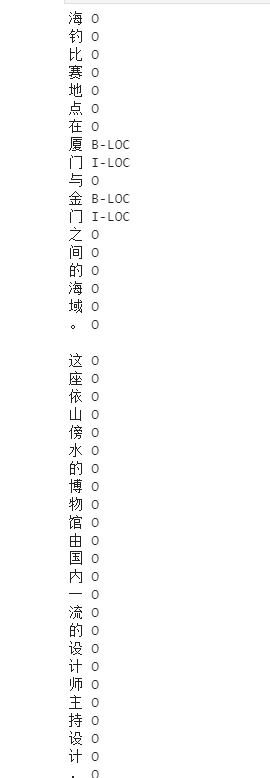

In [4]:
# 读取数据，对不足最大长度的句子进行padding。
# label2id:['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']
# vocab2id :{'海': 0, '钓': 1, '比': 2, '赛': 3, '地': 4, '点': 5, '在': 6, '厦': 7, '门': 8, '与': 9,...

def read_data(path,vocab2id,label2id,max_len):
    data_x = list()
    data_y = list()
    tmp_text = list()
    tmp_label = list()
    with open(path,'r',encoding = 'utf-8') as f:
        for line in f:
            line = line.strip()
            if len(line) == 0:  #数据集中以空行作为句子分隔符，说明前一个句子已经结束，tmp_text为vocab（id），tmp_label为label(id)
                # padding 至 max_len
                tmp_text += [len(vocab2id)] * (max_len - len(tmp_text))
                tmp_label += [0] * (max_len - len(tmp_label))
                #保存已经结束的句子并清空tmp
                data_x.append(tmp_text)
                data_y.append(tmp_label)
                tmp_text = list()
                tmp_label = list()
            else:#将字符和标签转换为相应的id放入tmp
                tmp_text.append(vocab2id[line[0]])#根据数据格式，line[0]为vocab,line[1]为空格
                tmp_label.append(label2id[line[2:]])#line[2:]为label
    print(u'{} include sequences {}'.format(path,len(data_x)))
    return np.array(data_x),np.array(data_y)

train_text,train_label = read_data('datasets/example.train',vocab2id,label2id,max_len)
dev_text,dev_label = read_data('datasets/example.dev',vocab2id,label2id,max_len)
test_text,test_label = read_data('datasets/example.test',vocab2id,label2id,max_len)

print(len(train_text))
print(len(train_label))
print(type(train_text))

datasets/example.train include sequences 20864
datasets/example.dev include sequences 2318
datasets/example.test include sequences 4636
20864
20864
<class 'numpy.ndarray'>


In [7]:
train_text[1000]

array([ 101,   87,  977, 1321,  796,   48,  818,   37,  638,   36,  198,
         28,  144,  127,  981,  645,  660,  638,   36,   35,  592,   91,
        340,  538,   37,   54,  531,  205, 1725,   67,   90,  109,   49,
        176,  182,    9,  479,  502,   35,  246,  654,  593,  594,  668,
        835,  250,  333,  144,   50,   91,   50,  354,  645,  660,  638,
         36,  250,  580,  144,  362,  373,  645,  660,  638,   36,   35,
        592,   91,  340,  910,   28,   13, 1527, 1054,  362,  373,  645,
        660,   67, 1267,  105,  592,   91,  380,  123,  362,  373,   53,
       1527, 1054,  380,  123,  362,  373,   53,  120,  121,  219,   54,
        362,  373,   53,  589,  401,   37,   54,  362,  373,   53,  120,
        121,  100,  610,   54,  362,  373,   82,  371,  362,  282,  175,
       1108,   53,  209,  218, 1105,  362,  373,  645,  660,   35,  237,
        361,  205,  340,  371,  185,  479,  502,   67,   27,  185,  479,
        502,   35,  340,  185,  132,  635,  479,  5

In [12]:
train_label[5]

array([1, 2, 2, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# 将数据通过Dataset加载。
# Dataset可以看作是相同类型“元素”的有序列表，可以通过Iterator对其中的元素进行读取，通过初始化不同的initializer实现读取不同的数据。

In [28]:
class mydataset(Dataset):
        def __init__(self): # 读取加载数据
            self._x=torch.LongTensor(train_text)
            self._y=torch.LongTensor(train_label)
            self._len=len(train_text)
            
        def __getitem__(self,item):
            return self._x[item],self._y[item]
        
        def __len__(self):# 返回整个数据的长度 
            return self._len
        
data=mydataset()

# 划分 训练集 测试集 
train_data,test_data=random_split(data,[round(0.8*data._len),round(0.2*data._len)])#这个参数有的版本没有 generator=torch.Generator().manual_seed(0)
#                     随机混乱顺序划分的     四舍五入


# 如图所示，输入文本经过预处理后得到字符的id，首先经过Embedding层得到字符向量，然后经过BiLSTM层得到句子表示，再经过CRF计算每个字符的标签得分，对于每个字符，选取得分最高的标签作为该字符的类别。

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class LSTM_CRF(nn.Module):#注意Module首字母需要大写
    def __init__(self,):
        super().__init__()
        self.embedding_size =128
        self.input_size=self.embedding_size
        self.hidden_size=self.embedding_size
        self.tags_num=7 # 根据 label2id 来的  {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6}
        self.embedding = nn.Embedding(len(vocab2id)+1,self.embedding_size,padding_idx=1)
        #                       词典的大小  每个词嵌入的维度 
        self.lstm = nn.LSTM(self.input_size,self.hidden_size,num_layers=1,bidirectional=True)#bidirectional=True 是否双向传播
        
        
        self.hidden_tag_linear = nn.Linear(2*self.hidden_size,self.tags_num)
        
        self.crf = CRF(self.tags_num) # 这里由于版本不同所以 不加这个： batch_first=True 假设没有这句话  那么输入模型的第一个句子序列的 mask都是true 假设有这句话 就没事 mask是正常的 
        
    
    def forward(self,x,y,mask):
        x=self.embedding(x)
        x=x.transpose(0,1) 
        
        lstm_out,(h_n,h_c) = self.lstm(x,None)
        logits=lstm_out.transpose(0,1)
        #经过一个全连接 
        logits=self.hidden_tag_linear(logits)
        
        # 计算CRF 条件对数似然，并返回其负值作为loss
        crf_loss = self.crf(logits,y,mask) #计算给定发射分数的标签序列的条件对数似然
        
         # 解码（预测序列标签）
        targets=self.crf.viterbi_decode(logits, mask=mask)
        return targets,crf_loss

# 这个函数是测试用来测试x_test y_test 数据 函数
def eval_test(model): 
    test_epoch_loss = []
    test_epoch_accuracy=[]
    with torch.no_grad():
        optimizer.zero_grad()
        for step, (train_x, train_y) in enumerate(test_loader):
            train_y=train_y.to(device)
            train_x=train_x.to(device)
            mask = torch.logical_not(torch.eq(train_x, torch.tensor(4465)))
            targets_pred_without_pad,crf_loss= model(train_x,train_y,mask)
            crf_loss=-crf_loss.mean()
            batch_accuracy_score=0
            for batch_idx,batch_pre_targets in enumerate(targets_pred_without_pad):
                #把padding的部分去掉 使用原始的真实句子长度与预测结果标签做准确计算
                targets_true_without_pad= torch.masked_select(train_y[batch_idx],mask[batch_idx]).cpu().numpy()
                metric = accuracy_score(targets_true_without_pad,batch_pre_targets)
                batch_accuracy_score=batch_accuracy_score+metric 
                
            test_epoch_loss.append(crf_loss.item())
            test_epoch_accuracy.append(batch_accuracy_score)
        
    return np.mean(test_epoch_loss),np.mean(test_epoch_accuracy)

In [53]:
# metric_func = lambda y_pred, y_true: accuracy_score(y_true, y_pred)
epochs = 50
batch_size =128
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True) # drop_last=True最后一个batch如果不足batch大小就不要了 
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

model = LSTM_CRF().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # 建立优化器实例
print(model)

sum_train_epoch_loss = []  # 存储每个epoch 下 训练train数据的loss
sum_test_epoch_loss = []  # 存储每个epoch 下 测试 test数据的loss

sum_train_epoch_accuracy = []  # 存储每个epoch 下 训练train数据的accuracy
sum_test_epoch_accuracy = []  # 存储每个epoch 下 测试 test数据的accuracy

best_test_loss = 1000000
for epoch in range(epochs):
    train_epoch_loss = []
    train_epoch_accuracy=[]
    for step, (train_x, train_y) in enumerate(train_loader):
        train_y=train_y.to(device)
        train_x=train_x.to(device)
        mask = torch.logical_not(torch.eq(train_x, torch.tensor(4465))).to(device)
        targets_pred_without_pad,crf_loss= model(train_x,train_y,mask)
        crf_loss=-crf_loss.mean()  # 输出的loss是一个列表 存储这batch中所有个数据的 loss  
        # 参考别人的：loss = tf.reduce_mean(-log_likelihood)#CRF的log_likelihood是越大越好，优化器的实现是loss越小越好，因此loss与log_likelihood相反
#         print(crf_loss)
        crf_loss.backward()  # 反向传播计算梯度
        optimizer.step()  # 更新参数
        batch_accuracy_score=0
        for batch_idx,batch_pred_targets in enumerate(targets_pred_without_pad):
             #把padding的部分去掉 使用原始的真实句子长度与预测结果标签做准确计算
            targets_true_without_pad= torch.masked_select(train_y[batch_idx],mask[batch_idx]).cpu().numpy()
            metric = accuracy_score(targets_true_without_pad,batch_pred_targets)
            batch_accuracy_score=batch_accuracy_score+metric      
        train_epoch_loss.append(crf_loss.item())
        train_epoch_accuracy.append(batch_accuracy_score)  
        
        
    train_epoch_accuracy=np.mean(train_epoch_accuracy)# 训练数据一个epoch平均的准确率
    train_epoch_loss = np.mean(train_epoch_loss)      # 训练数据一个epoch平均的loss 
    test_epoch_loss,test_epoch_accuracy = eval_test(model) # 测试数据的全部数据的平均loss 测试数据的全部数据的平均accuracy
    
    if test_epoch_loss<best_test_loss:
        best_test_loss=test_epoch_loss
        print("best_test_loss",best_test_loss)
        best_model=model
    sum_train_epoch_loss.append(train_epoch_loss)
    sum_test_epoch_loss.append(test_epoch_loss)
    sum_train_epoch_accuracy.append(train_epoch_accuracy)
    sum_test_epoch_accuracy.append(test_epoch_accuracy)
    
    print("epoch:" + str(epoch) + "  train_epoch_loss： " + str(train_epoch_loss) + "  test_epoch_loss: " + str(test_epoch_loss)+" test_epoch_accuracy "+str(test_epoch_accuracy))

torch.save(best_model, 'best_model.pth')


LSTM_CRF(
  (embedding): Embedding(4466, 128, padding_idx=1)
  (lstm): LSTM(128, 128, bidirectional=True)
  (hidden_tag_linear): Linear(in_features=256, out_features=7, bias=True)
  (crf): CRF()
)
best_test_loss 32.5545454621315
epoch:0  train_epoch_loss： 36.40396825350248  test_epoch_loss: 32.5545454621315 test_epoch_accuracy 114.14108853416046
best_test_loss 16.079272150993347
epoch:1  train_epoch_loss： 20.361206582876353  test_epoch_loss: 16.079272150993347 test_epoch_accuracy 114.18538191337777
best_test_loss 10.68703219294548
epoch:2  train_epoch_loss： 11.68385171523461  test_epoch_loss: 10.68703219294548 test_epoch_accuracy 119.01755740537118
best_test_loss 8.508385390043259
epoch:3  train_epoch_loss： 8.287390595216017  test_epoch_loss: 8.508385390043259 test_epoch_accuracy 118.86434984995508
epoch:4  train_epoch_loss： 6.959049364236685  test_epoch_loss: 8.665611237287521 test_epoch_accuracy 120.09138139416193
best_test_loss 5.827164649963379
epoch:5  train_epoch_loss： 6.94188902

In [54]:
#模型加载：
model.load_state_dict(torch.load('best_model.pth').cpu().state_dict())
model.eval()
# with torch.no_grad():
#     optimizer.zero_grad()
#     for step, (test_x, test_y) in enumerate(test_loader):
#         y_pre = model(test_x,19).cpu()
#         y_pre=torch.argmax(y_pre,dim=1)
#         print(y_pre)
#         print(test_y)
#         accuracy=accuracy_score(test_y, y_pre) 
#         print(accuracy)
label2id=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']
test_epoch_loss = []
test_epoch_accuracy=[]
with torch.no_grad():
        optimizer.zero_grad()
        for step, (train_x, train_y) in enumerate(test_loader):
            train_y=train_y.to(device)
            train_x=train_x.to(device)
            mask = torch.logical_not(torch.eq(train_x, torch.tensor(4465)))
            targets_pred_without_pad,crf_loss= model(train_x,train_y,mask)
            crf_loss=-crf_loss.mean()
            batch_accuracy_score=0
            for batch_idx,batch_pre_targets in enumerate(targets_pred_without_pad):
                #把padding的部分去掉 使用原始的真实句子长度与预测结果标签做准确计算
                targets_true_without_pad= torch.masked_select(train_y[batch_idx],mask[batch_idx]).cpu().numpy()
                train_x_juzi=torch.masked_select(train_x[batch_idx],mask[batch_idx]).cpu().numpy()
                juzi=[]
                for i in train_x_juzi:
                    juzi.append(id2vocab[i])
                pre_label=[]
                for i in batch_pre_targets:
                    pre_label.append(label2id[i])
                    
                print("真实句子",juzi)#''.join(juzi)
                print("预测标签",pre_label)
                
#                 print("真实标签",list(targets_true_without_pad))
#                 print("预测标签",batch_pre_targets)
                metric = accuracy_score(targets_true_without_pad,batch_pre_targets)
                print(metric)
                print("-"*100)
            break
                
                
                
                
                
#                 metric = accuracy_score(targets_true_without_pad,batch_pre_targets)
#                 batch_accuracy_score=batch_accuracy_score+metric 
            
#             test_epoch_loss.append(crf_loss.item())
#             test_epoch_accuracy.append(batch_accuracy_score)
            
# print(np.mean(test_epoch_accuracy))

真实句子 ['目', '前', '，', '全', '国', '各', '行', '各', '业', '都', '活', '跃', '着', '大', '批', '留', '学', '回', '国', '人', '员', '，', '广', '大', '在', '外', '留', '学', '人', '员', '也', '正', '在', '以', '多', '种', '适', '当', '的', '方', '式', '为', '国', '家', '作', '贡', '献', '。']
预测标签 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
1.0
----------------------------------------------------------------------------------------------------
真实句子 ['1', '9', '7', '7', '年', '毕', '业', '于', '南', '京', '艺', '术', '学', '院', '，', '曾', '留', '校', '任', '教', '。']
预测标签 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
1.0
----------------------------------------------------------------------------------------------------
真实句子 ['该', '校', '有', '1', '4', '9', '3', '名', '农', '

In [57]:
!pip install flask -i https://pypi.tuna.tsinghua.edu.cn/simple/ --trusted-host pypi.douban.com

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/8f/b6/b4fdcb6d01ee20f9cfe81dcf9d3cd6c2f874b996f186f1c0b898c4a59c04/Flask-2.0.2-py3-none-any.whl (95 kB)
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/1e/73/51137805d1b8d97367a8a77cae4a792af14bb7ce58fbd071af294c740cf0/Werkzeug-2.0.2-py3-none-any.whl (288 kB)
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/9c/96/26f935afba9cd6140216da5add223a0c465b99d0f112b68a4ca426441019/itsdangerous-2.0.1-py3-none-any.whl (18 kB)
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/94/42/d8bca8e99789bcc35dfa9b03acaa8b518720d6e060163745bc2bf2ead842/Jinja2-3.0.2-py3-none-any.whl (133 kB)
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 1.0.1
    Uninstalling Werkzeug-1.0.1:
      Successfully uninstalled Werkzeug-1.0.1
  Attempting uninstall: Jinja2
    Found existing installation: Jinja2 2.11.2
    Uninstalling Jinja2-2.11.2:
      S

In [58]:
from flask import Flask, request, jsonify, request, abort
import io
import sys
import pickle
import json